# Membrane Test Calculations

This guide/tutorial will demonstrate how to calculate holding current (Ih), membrane resistance (Rm), access resistance (Ra), and membrane capacitance (Cm) from a single step in voltage-clamp configuration.

### Prepare the environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
np.set_printoptions(precision=3)

### Load some sample data
Let's load some sample data and inspect it. This is part of a real recording where the voltage clamp went from -70 mV to -80 mV and back.

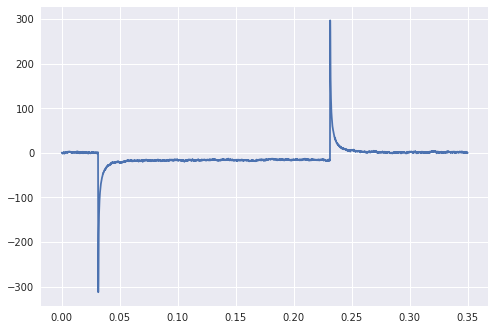

In [2]:
data=np.load("memtest.npy")
rate=20000 # 20 kHz sample rate
times=np.arange(len(data))/rate
plt.plot(times,data);

## Separate data by epoch

* In this example, the points are hard coded
* Using pyabf, epoch start points are defined in `abf.epochStartPoint`

In [3]:
stepI1=626
stepI2=stepI1+4000

data1=data[:stepI1]
data2=data[stepI1:stepI2]
data3=data[stepI2:]

## Calculate steady-state currents (and Ih)

Although the first bit after a voltage step is dominated by a capacitive transient, the steady state current for each voltage step can be measured by averaging the last 50% of each section.

Although the pre-epoch segment could be used to determine Ih, a more ideal way is to use epoch A as your voltage step and make epoch B a reversion to your holding voltage. This will produce a longer segment allowing more time for averaging.

In [4]:
mean1=np.average(data1) # average the whole step
mean2=np.average(data2[int(-len(data2)/2):]) # average just the last 50% of the step
mean3=np.average(data3[int(-len(data3)/2):]) # average just the last 50% of the step
print("step means:",mean1,mean2,mean3)

Ih=mean3 # this is longer (more accurate) than the smaller pre-epoch piece of data
print("holding current (Ih):",Ih)

step means: 0.581396 -16.0373 1.17611
holding current (Ih): 1.17611


Let's look graphically at our calculated means

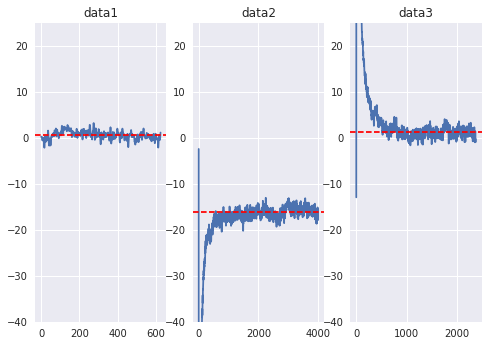

In [5]:
ax1=plt.subplot(131)
plt.plot(data1)
plt.axhline(mean1,color='r',ls='--')
plt.title("data1")

plt.subplot(132,sharey=ax1)
plt.plot(data2)
plt.axhline(mean2,color='r',ls='--')
plt.title("data2")

plt.subplot(133,sharey=ax1)
plt.plot(data3)
plt.axhline(mean3,color='r',ls='--')
plt.title("data3")

plt.axis([None,None,-40,25]); # zoom in the interesting area

## Calculate membrane resistance (Rm)

Rm can be calcuated by comparing the means of the step currents (delta I, `dI`) to the change in clamp voltage (delta V, `dV`) that caused it.
* `V=IR`
* `R=V/I`
* `R=dV/dI`

_note: This equation assumes units are V, A, and Ohms_

In [6]:
dV=10 # change in voltage (known from command waveform)
dI=np.abs(mean3-mean2) # change in current (measured)
print("dV: %.02f mV"%dV)
print("dI: %.02f pA"%dI)

Rm=(dV/1e3)/(dI/1e12) # mV to V and pA to A
Rm=Rm/1e6 # Ohm to MOhm
print("Rm: %.02f MOhm"%Rm)

dV: 10.00 mV
dI: 17.21 pA
Rm: 580.94 MOhm


## Estimate access resistance (Ra) by reporting the peak transient
To measure Ra you need to first calculate membrane capacitance (Cm). That's a lot of work. If you want to assess cell stability without going through all the work (and computational time) of calculating Cm, you could just report the average transient size. An abrupt change in Ra will change this size, so it's a good indicator of stability over long-duration experiments.

In [83]:
peak1=np.abs(np.min(data2)-mean2)
peak2=np.abs(np.max(data3)-mean3)
peakTransient=np.average((peak1,peak2))
print("peak transient: %.02f pA"%peakTransient)

Ra=(dV*1e-3)/(peakTransient*1e-12)
Ra=Ra/1e6 # convert to MOhm units
print("Ra: %.02f MOhm"%Ra)

peak transient: 295.99 pA
Ra: 33.79 MOhm


## Calculate tau (membrane time constant)

### EnsureSciPy is available
_This isn't a given, since SciPy is massively huge and difficult to compile on some systems._

In [60]:
try:
    import scipy.optimize
except ModuleNotFoundError:
    print("Scipy is not installed. Cm will not be calculated.")

### Create an ideal curve
Rather than calculate tau twice (one for the step down, another for the step up) let's average the two together. This can be done by centering them at 0 (subtracing out their steady-state currents) and averaging them together.

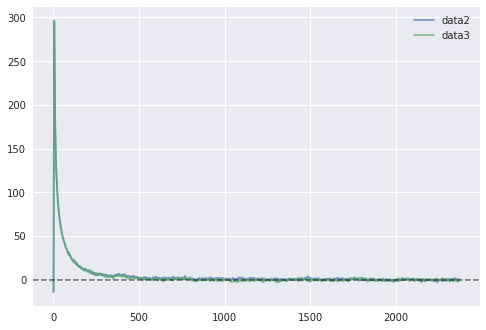

In [61]:
chunkSize=np.min((len(data2),len(data3)))
chunks=np.empty((2,chunkSize)) # will hold both chunks

chunks[0]=-(data2[:chunkSize]-mean2) # invert data 2
chunks[1]=data3[:chunkSize]-mean3

plt.plot(chunks[0],alpha=.7,label="data2")
plt.plot(chunks[1],alpha=.7,label="data3")
plt.axhline(0,ls='--',color='k',alpha=.5);
plt.legend();

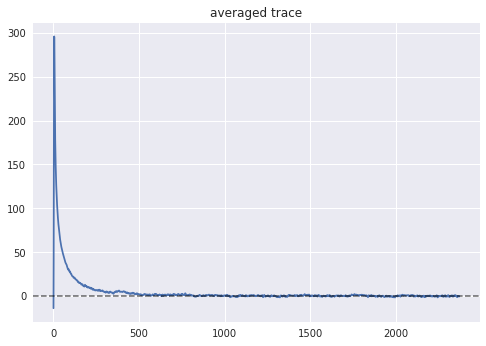

In [62]:
trace=np.average(chunks,axis=0)
plt.plot(trace)
plt.axhline(0,ls='--',color='k',alpha=.5);
plt.title("averaged trace");

### Trim-out the rising phase

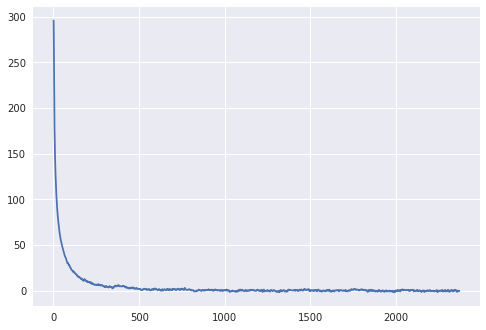

In [63]:
tracePeak=np.max(trace)
traceIndex=np.where(trace==tracePeak)[0]
trace=trace[int(traceIndex):]
plt.plot(trace);

### Determine the area of the curve to measure
In an ideal world you'd fit between 80% and 20% (relative to peak and steady state). In reality the hardware low-pass filtering will really mess you up on data values which change quickly. This especially disorts the top-half of the curve. For this reason, I prefer to fit the lower portion of the curve.

295.988204956


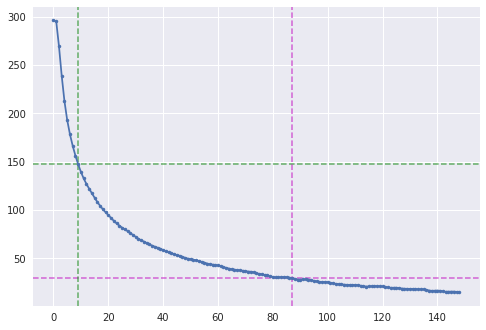

In [64]:
def firstIndexBelow(data,target):
    """returns the first index of an array below a given value."""
    for i,val in enumerate(data):
        if val<target:
            return i
    return None

print(tracePeak)
iTop=firstIndexBelow(trace,tracePeak*.5)
iBot=firstIndexBelow(trace,tracePeak*.1)

# let's trim-off data less than 10% of the peak
iEnd=firstIndexBelow(trace,tracePeak*.05)
trace=trace[:iEnd]

plt.axhline(trace[iTop],color='g',ls='--',alpha=.5)
plt.axhline(trace[iBot],color='m',ls='--',alpha=.5)
plt.axvline(iTop,color='g',ls='--',alpha=.5)
plt.axvline(iBot,color='m',ls='--',alpha=.5)
plt.plot(trace,'.-');

### Isolate just the points you want to fit

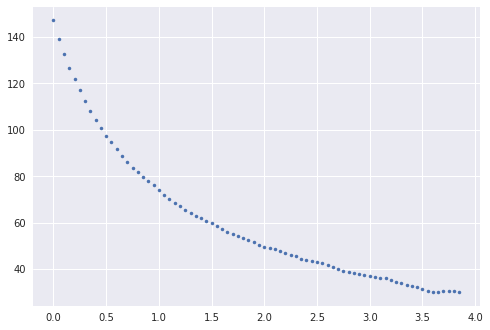

In [65]:
fitThis=trace[iTop:iBot]
x=np.arange(len(fitThis))/rate*1000 # ms units
plt.plot(x,fitThis,'.');

### Prepare mono-exponential function to fit against

In [66]:
def algoMonoExp(x, m, t, b):
    return m*np.exp(-t*x)+b

### Perform the curve fit

_note: This requires SciPy. Add a function that does this without SciPy and you can omit the entire package!_

In [67]:
params, cv = scipy.optimize.curve_fit(algoMonoExp, x, fitThis, p0=(1,1e-6,1))
m,t,b=params

### Assess the fit

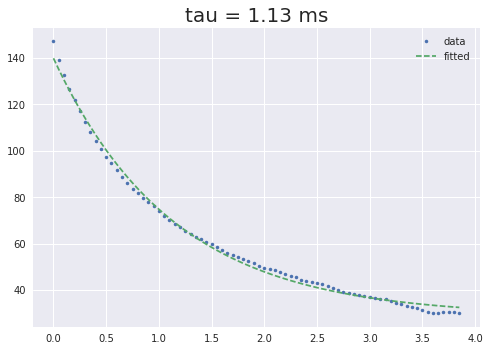

In [68]:
plt.plot(x,fitThis,'.',label="data")
plt.plot(x,algoMonoExp(x,m,t,b),'--',label="fitted")
plt.legend()
tau=1/t
plt.title("tau = %.02f ms"%tau,fontsize=20);

Membrane capacitance (Cm) is just tau (sec) / Ra (Ohms)

In [79]:
Cm=((tau*1e-3)/Ra)*1e12 # pF
print("Cm: %.02f pF"%Cm)

Cm: 33.59 pF


We now have all intrinsic membrane properties for this sweep:

In [84]:
print("Ih: %.02f pA"%(Ih))
print("Rm: %.02f MOhm"%(Rm))
print("Ra: %.02f MOhm"%(Ra))
print("Cm: %.02f pF"%(Cm))

Ih: 1.18 pA
Rm: 580.94 MOhm
Ra: 33.79 MOhm
Cm: 33.59 pF
